### Set up the environment and import libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import logistic
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
# Load the extracted data
data_censored = pd.read_csv("data_censored.csv")

# Display the first few rows
print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


### Implement the trial sequence class

In [4]:
class TrialSequence:
    def __init__(self, estimand="ITT"):
        """Initialize a Trial Sequence object
        
        Parameters:
        -----------
        estimand : str
            Either "ITT" (Intention-to-treat) or "PP" (Per-protocol)
        """
        self.estimand = estimand
        self.data = None
        self.id_col = None
        self.period_col = None
        self.treatment_col = None
        self.outcome_col = None
        self.eligible_col = None
        self.censor_event_col = None
        self.switch_weights = None
        self.censor_weights = None
        self.expanded_data = None
        self.outcome_model = None
        
    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        """Set the data for the trial sequence
        
        Parameters:
        -----------
        data : pandas.DataFrame
            The observational data
        id_col : str
            Column name for patient ID
        period_col : str
            Column name for time period
        treatment_col : str
            Column name for treatment indicator
        outcome_col : str
            Column name for outcome
        eligible_col : str
            Column name for eligibility indicator
        """
        self.data = data
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        
        # Add a print statement similar to the R output
        print(f"Data loaded: {len(data)} observations from {data[id_col].nunique()} patients")
        return self

### Implement the weight model functions

In [5]:
def set_switch_weight_model(self, numerator_formula, denominator_formula):
    """Set the model for treatment switching weights
    
    Parameters:
    -----------
    numerator_formula : str
        Formula for the numerator model
    denominator_formula : str
        Formula for the denominator model
    """
    if self.estimand == "ITT":
        print("Switch weights are not used for ITT estimand")
        return self
        
    self.switch_weights = {
        "numerator_formula": numerator_formula,
        "denominator_formula": denominator_formula,
        "models": None
    }
    return self

def set_censor_weight_model(self, censor_event_col, numerator_formula, denominator_formula, pool_models="none"):
    """Set the model for censoring weights
    
    Parameters:
    -----------
    censor_event_col : str
        Column name for the censoring indicator
    numerator_formula : str
        Formula for the numerator model
    denominator_formula : str
        Formula for the denominator model
    pool_models : str
        How to pool models across treatment arms: "none", "numerator", or "all"
    """
    self.censor_event_col = censor_event_col
    self.censor_weights = {
        "numerator_formula": numerator_formula,
        "denominator_formula": denominator_formula,
        "pool_models": pool_models,
        "models": None
    }
    return self

### Implement the calculate_weights function

In [16]:
def calculate_weights(self):
    """Calculate the inverse probability weights"""
    data = self.data.copy()
    
    # Add weight columns
    data['wt'] = 1.0  # For switch weights
    data['wtC'] = 1.0  # For censoring weights
    
    # Calculate censoring weights if model is specified
    if self.censor_weights is not None:
        data = self._calculate_censor_weights(data)
    
    # Calculate switch weights if model is specified and estimand is PP
    if self.switch_weights is not None and self.estimand == "PP":
        data = self._calculate_switch_weights(data)
    
    self.data = data
    return self

def _calculate_censor_weights(self, data):
    """Calculate the censoring weights"""
    # Implementation details will depend on your specific models
    # Here's a simplified version:
    
    censor_models = {}
    censor_probs = {}
    
    # Define the outcome variable (1 - censored)
    data['censor_outcome'] = 1 - data[self.censor_event_col]
    
    # Fit models based on pooling strategy
    if self.censor_weights["pool_models"] == "none":
        # Separate models for each treatment
        for trt in [0, 1]:
            # Numerator model
            num_formula = f"censor_outcome ~ {self.censor_weights['numerator_formula']}"
            num_model = smf.glm(formula=num_formula, 
                               data=data[data[self.treatment_col] == trt], 
                               family=sm.families.Binomial()).fit()
            censor_models[f'n{trt}'] = num_model
            
            # Denominator model
            denom_formula = f"censor_outcome ~ {self.censor_weights['denominator_formula']}"
            denom_model = smf.glm(formula=denom_formula, 
                                 data=data[data[self.treatment_col] == trt], 
                                 family=sm.families.Binomial()).fit()
            censor_models[f'd{trt}'] = denom_model
            
            # Calculate probabilities
            num_probs = num_model.predict(data[data[self.treatment_col] == trt])
            denom_probs = denom_model.predict(data[data[self.treatment_col] == trt])
            
            # Store probabilities
            mask = data[self.treatment_col] == trt
            data.loc[mask, 'num_prob'] = num_probs
            data.loc[mask, 'denom_prob'] = denom_probs
    else:
        # Pooled models (simplified)
        # Numerator model
        num_formula = f"censor_outcome ~ {self.censor_weights['numerator_formula']}"
        num_model = smf.glm(formula=num_formula, 
                           data=data, 
                           family=sm.families.Binomial()).fit()
        censor_models['n'] = num_model
        
        # Denominator models still separate by treatment
        for trt in [0, 1]:
            denom_formula = f"censor_outcome ~ {self.censor_weights['denominator_formula']}"
            denom_model = smf.glm(formula=denom_formula, 
                                 data=data[data[self.treatment_col] == trt], 
                                 family=sm.families.Binomial()).fit()
            censor_models[f'd{trt}'] = denom_model
        
        # Calculate probabilities
        data['num_prob'] = num_model.predict(data)
        
        for trt in [0, 1]:
            mask = data[self.treatment_col] == trt
            data.loc[mask, 'denom_prob'] = censor_models[f'd{trt}'].predict(data[mask])
    
    # Calculate weights (stabilized)
    data['wtC'] = data['num_prob'] / data['denom_prob']
    
    # Save models for later reference
    self.censor_weights["models"] = censor_models
    
    # Clean up temporary columns
    data = data.drop(['censor_outcome', 'num_prob', 'denom_prob'], axis=1)
    
    return data

    

### Implement trial expansion

In [7]:
def set_expansion_options(self, chunk_size=500):
    """Set options for trial expansion
    
    Parameters:
    -----------
    chunk_size : int
        Number of patients to include in each expansion iteration
    """
    self.expansion_options = {
        "chunk_size": chunk_size,
        "censor_at_switch": self.estimand == "PP"  # True for PP, False for ITT
    }
    return self

def expand_trials(self):
    """Expand the observational data into a sequence of trials"""
    # Identify eligible subjects
    eligible_periods = self.data[self.data[self.eligible_col] == 1]
    unique_ids = eligible_periods[self.id_col].unique()
    
    # Initialize expanded data
    expanded_data = []
    
    # Process in chunks
    for i in range(0, len(unique_ids), self.expansion_options["chunk_size"]):
        chunk_ids = unique_ids[i:i+self.expansion_options["chunk_size"]]
        chunk_data = self.data[self.data[self.id_col].isin(chunk_ids)].copy()
        
        # For each eligible period, create a trial
        for _, row in eligible_periods[eligible_periods[self.id_col].isin(chunk_ids)].iterrows():
            patient_id = row[self.id_col]
            trial_period = row[self.period_col]
            
            # Get patient data starting from trial_period
            patient_data = chunk_data[
                (chunk_data[self.id_col] == patient_id) & 
                (chunk_data[self.period_col] >= trial_period)
            ].copy()
            
            if len(patient_data) == 0:
                continue
                
            # Assign treatment based on first period
            assigned_treatment = patient_data.iloc[0][self.treatment_col]
            
            # Reset followup time
            patient_data['followup_time'] = patient_data[self.period_col] - trial_period
            
            # Add trial information
            patient_data['trial_period'] = trial_period
            patient_data['assigned_treatment'] = assigned_treatment
            
            # Handle censoring for PP estimand
            if self.expansion_options["censor_at_switch"]:
                # Find first time treatment switches from assigned
                switch_idx = patient_data[
                    patient_data[self.treatment_col] != assigned_treatment
                ].index.min() if any(patient_data[self.treatment_col] != assigned_treatment) else None
                
                if switch_idx is not None:
                    # Keep data up to the switch
                    patient_data = patient_data.loc[:switch_idx].copy()
            
            # Add to expanded data
            expanded_data.append(patient_data)
    
    # Combine all expanded data
    if expanded_data:
        self.expanded_data = pd.concat(expanded_data, ignore_index=True)
        print(f"Expanded data created: {len(self.expanded_data)} observations")
    else:
        print("No expanded data created")
    
    return self

### Implement outcome model

In [8]:
def set_outcome_model(self, adjustment_terms=None):
    """Set the outcome model
    
    Parameters:
    -----------
    adjustment_terms : str
        Formula string for adjustment variables
    """
    # Basic formula includes treatment and time
    formula_parts = ["assigned_treatment"]
    
    # Add adjustment terms if provided
    if adjustment_terms:
        formula_parts.append(adjustment_terms)
    
    # Add time effects
    formula_parts.extend([
        "followup_time", 
        "I(followup_time**2)", 
        "trial_period", 
        "I(trial_period**2)"
    ])
    
    self.outcome_model_formula = " + ".join(formula_parts)
    print(f"Outcome model set: {self.outcome_model_formula}")
    return self

def fit_msm(self, weight_cols=None, modify_weights=None):
    """Fit the marginal structural model
    
    Parameters:
    -----------
    weight_cols : list
        List of column names to multiply for final weights
    modify_weights : function
        Function to modify weights (e.g., truncation)
    """
    if self.expanded_data is None:
        print("No expanded data available. Run expand_trials() first.")
        return self
    
    # Create a copy of the data for modeling
    model_data = self.expanded_data.copy()
    
    # Calculate combined weights
    if weight_cols:
        model_data['weight'] = 1.0
        for col in weight_cols:
            if col in model_data.columns:
                model_data['weight'] *= model_data[col]
    else:
        # Default to using wt and wtC
        model_data['weight'] = model_data['wt'] * model_data['wtC']
    
    # Modify weights if requested
    if modify_weights:
        model_data['weight'] = modify_weights(model_data['weight'])
    
    # Fit the model
    formula = f"{self.outcome_col} ~ {self.outcome_model_formula}"
    self.outcome_model = smf.glm(
        formula=formula,
        data=model_data,
        family=sm.families.Binomial(),
        freq_weights=model_data['weight']
    ).fit()
    
    # Print model summary
    print("Model Summary:")
    print(self.outcome_model.summary())
    
    return self

### Prediction and visualization

In [9]:
def predict(self, newdata=None, predict_times=None, type="survival"):
    """Generate predictions from the fitted model
    
    Parameters:
    -----------
    newdata : pandas.DataFrame
        New data for prediction. If None, uses the first trial period
    predict_times : list
        List of times for prediction
    type : str
        Type of prediction: "survival" or "cumulative_incidence"
    
    Returns:
    --------
    dict
        Dictionary of prediction results
    """
    if self.outcome_model is None:
        print("No outcome model fitted. Run fit_msm() first.")
        return None
    
    if newdata is None:
        # Use the first trial period as default
        newdata = self.expanded_data[self.expanded_data['trial_period'] == 0].iloc[0:1].copy()
    
    if predict_times is None:
        predict_times = list(range(11))  # 0 to 10 by default
    
    # Create prediction dataset
    pred_data = []
    for t in predict_times:
        for trt in [0, 1]:
            row = newdata.iloc[0].copy()
            row['followup_time'] = t
            row['assigned_treatment'] = trt
            pred_data.append(row)
    
    pred_df = pd.DataFrame(pred_data)
    
    # Make predictions
    pred_df['pred_prob'] = self.outcome_model.predict(pred_df)
    
    # Calculate survival or cumulative incidence
    results = {0: {}, 1: {}, 'difference': {}}
    
    for trt in [0, 1]:
        trt_data = pred_df[pred_df['assigned_treatment'] == trt].sort_values('followup_time')
        
        if type == "survival":
            # Calculate survival (1 - cumulative hazard)
            trt_data['survival'] = 1 - trt_data['pred_prob']
            results[trt] = trt_data[['followup_time', 'survival']].copy()
        else:
            # Cumulative incidence
            trt_data['cum_incidence'] = trt_data['pred_prob']
            results[trt] = trt_data[['followup_time', 'cum_incidence']].copy()
    
    # Calculate difference
    if type == "survival":
        results['difference'] = pd.merge(
            results[1], 
            results[0], 
            on='followup_time', 
            suffixes=('_1', '_0')
        )
        results['difference']['survival_diff'] = results['difference']['survival_1'] - results['difference']['survival_0']
    else:
        results['difference'] = pd.merge(
            results[1], 
            results[0], 
            on='followup_time', 
            suffixes=('_1', '_0')
        )
        results['difference']['cum_incidence_diff'] = results['difference']['cum_incidence_1'] - results['difference']['cum_incidence_0']
    
    return results

### Complete class implementation

In [10]:
# Add the methods to the TrialSequence class
TrialSequence.set_switch_weight_model = set_switch_weight_model
TrialSequence.set_censor_weight_model = set_censor_weight_model
TrialSequence.calculate_weights = calculate_weights
TrialSequence._calculate_censor_weights = _calculate_censor_weights
TrialSequence.set_expansion_options = set_expansion_options
TrialSequence.expand_trials = expand_trials
TrialSequence.set_outcome_model = set_outcome_model
TrialSequence.fit_msm = fit_msm
TrialSequence.predict = predict

### Usage example

Data loaded: 725 observations from 89 patients
Data loaded: 725 observations from 89 patients
Outcome model set: assigned_treatment + x2 + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)
Outcome model set: assigned_treatment + followup_time + I(followup_time**2) + trial_period + I(trial_period**2)
Expanded data created: 1558 observations
Expanded data created: 610 observations
Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1558
Model:                            GLM   Df Residuals:                  1546.15
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 09 Mar 2025   Deviance:                       137.58
Time:                       

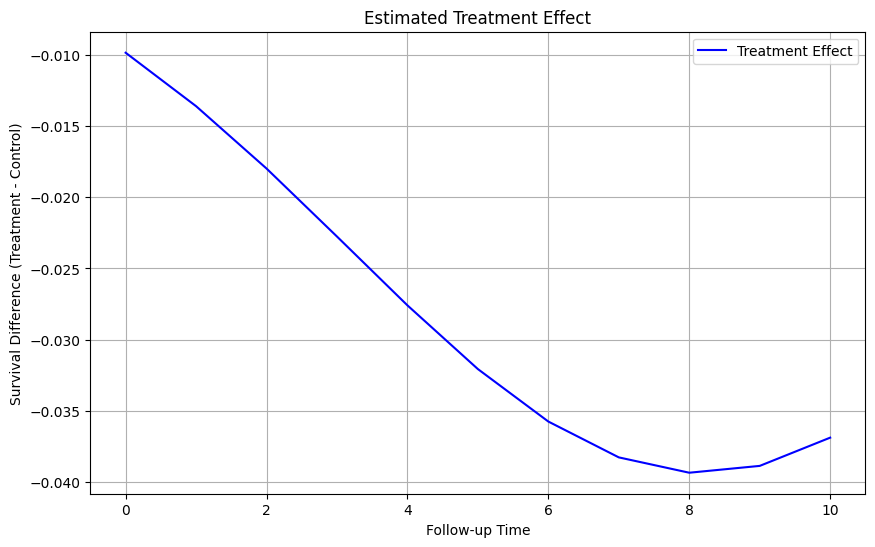

In [15]:
# Create trial sequences
trial_itt = TrialSequence(estimand="ITT")
trial_pp = TrialSequence(estimand="PP")

# Set data
trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Set weight models
trial_pp.set_switch_weight_model(
    numerator_formula="age",
    denominator_formula="age + x1 + x3"
)

trial_itt.set_censor_weight_model(
    censor_event_col="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1",
    pool_models="numerator"
)

trial_pp.set_censor_weight_model(
    censor_event_col="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1",
    pool_models="none"
)

# Calculate weights
trial_itt.calculate_weights()
trial_pp.calculate_weights()

# Set outcome models
trial_itt.set_outcome_model(adjustment_terms="x2")
trial_pp.set_outcome_model()

# Set expansion options
trial_itt.set_expansion_options(chunk_size=500)
trial_pp.set_expansion_options(chunk_size=500)

# Expand trials
trial_itt.expand_trials()
trial_pp.expand_trials()

# Fit marginal structural models
def winsorize_weights(w, q=0.99):
    """Winsorize weights at the specified quantile"""
    q_val = np.quantile(w, q)
    return np.minimum(w, q_val)

trial_itt.fit_msm(
    weight_cols=["wtC"],
    modify_weights=winsorize_weights
)

# Make predictions
preds = trial_itt.predict(predict_times=range(11), type="survival")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(preds['difference']['followup_time'], preds['difference']['survival_diff'], 'b-', label='Treatment Effect')
plt.xlabel('Follow-up Time')
plt.ylabel('Survival Difference (Treatment - Control)')
plt.title('Estimated Treatment Effect')
plt.grid(True)
plt.legend()
plt.show()